In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/螺纹期货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['螺纹期货价格'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,螺纹盘面成本,螺纹盘面利润,螺纹期货价格
2025-11-17,NaN,NaN,NaN
2025-11-18,NaN,NaN,NaN
2025-11-19,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/螺纹盘面利润_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-11-17,-358.4
3,2025-11-18,-356.6
2,2025-11-19,-356.6
1,2025-11-20,-356.7
0,2025-11-21,-356.7


In [6]:
file_path2 = os.path.expanduser("eta/螺纹盘面成本_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['螺纹盘面成本'])
sheet2 = sheet2.dropna()

sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,螺纹盘面成本_预测
19,2025-10-27,3407.457096
18,2025-10-28,3416.620622
17,2025-10-29,3442.732017
16,2025-10-30,3443.469592
15,2025-10-31,3455.813738


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['螺纹盘面利润'] = sheet_daily['螺纹盘面利润'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '螺纹盘面成本_预测']],
    on='Date',
    how='left'
)
sheet_daily['螺纹盘面成本'] = sheet_daily['螺纹盘面成本'].fillna(sheet_daily['螺纹盘面成本_预测'])
sheet_daily = sheet_daily.drop(columns=['螺纹盘面成本_预测'])


sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,螺纹盘面成本,螺纹盘面利润,螺纹期货价格
4038,2025-11-10,3456.603821,-360.1,NaN
4039,2025-11-11,3458.969657,-357.0,NaN
4040,2025-11-12,3438.652764,-356.8,NaN
4041,2025-11-13,3406.214780,-356.8,NaN
4042,2025-11-14,3400.965156,-356.6,NaN
4043,2025-11-17,3420.298364,-358.4,NaN
4044,2025-11-18,3405.054003,-356.6,NaN
4045,2025-11-19,3402.161481,-356.6,NaN
4046,2025-11-20,3398.068829,-356.7,NaN
4047,2025-11-21,3403.924788,-356.7,NaN


In [8]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['螺纹期货价格_预测'] = sheet_daily['螺纹盘面利润']  + sheet_daily['螺纹盘面成本']
sheet_daily.tail()

,Date,螺纹盘面成本,螺纹盘面利润,螺纹期货价格,螺纹期货价格_预测
4043,2025-11-17,3420.298364,-358.4,NaN,3061.898364
4044,2025-11-18,3405.054003,-356.6,NaN,3048.454003
4045,2025-11-19,3402.161481,-356.6,NaN,3045.561481
4046,2025-11-20,3398.068829,-356.7,NaN,3041.368829
4047,2025-11-21,3403.924788,-356.7,NaN,3047.224788


In [9]:
last_day = sheet_daily['Date'][sheet_daily['螺纹期货价格'].last_valid_index()]

---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '螺纹期货价格']]
historical.columns = ['Date', '螺纹期货价格']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '螺纹期货价格_预测']]
forecast.columns = ['Date', '螺纹期货价格_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/螺纹期货价格_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily.head() 

,Date,螺纹期货价格,螺纹期货价格_预测
600,2025/11/21,NaN,3047.224788
599,2025/11/20,NaN,3041.368829
598,2025/11/19,NaN,3045.561481
597,2025/11/18,NaN,3048.454003
596,2025/11/17,NaN,3061.898364


In [11]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '螺纹期货价格']]
historical_monthly.columns = ['Date', '螺纹期货价格']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '螺纹期货价格_预测']]
forecast_monthly.columns = ['Date', '螺纹期货价格_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/螺纹期货价格_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,螺纹期货价格,螺纹期货价格_预测
29,2025/11/30,NaN,3069.052840
28,2025/10/31,3061.666667,3070.252533
27,2025/09/30,3132.909091,3132.909091
26,2025/08/31,3174.238095,3174.238095
25,2025/07/31,3168.130435,3168.130435


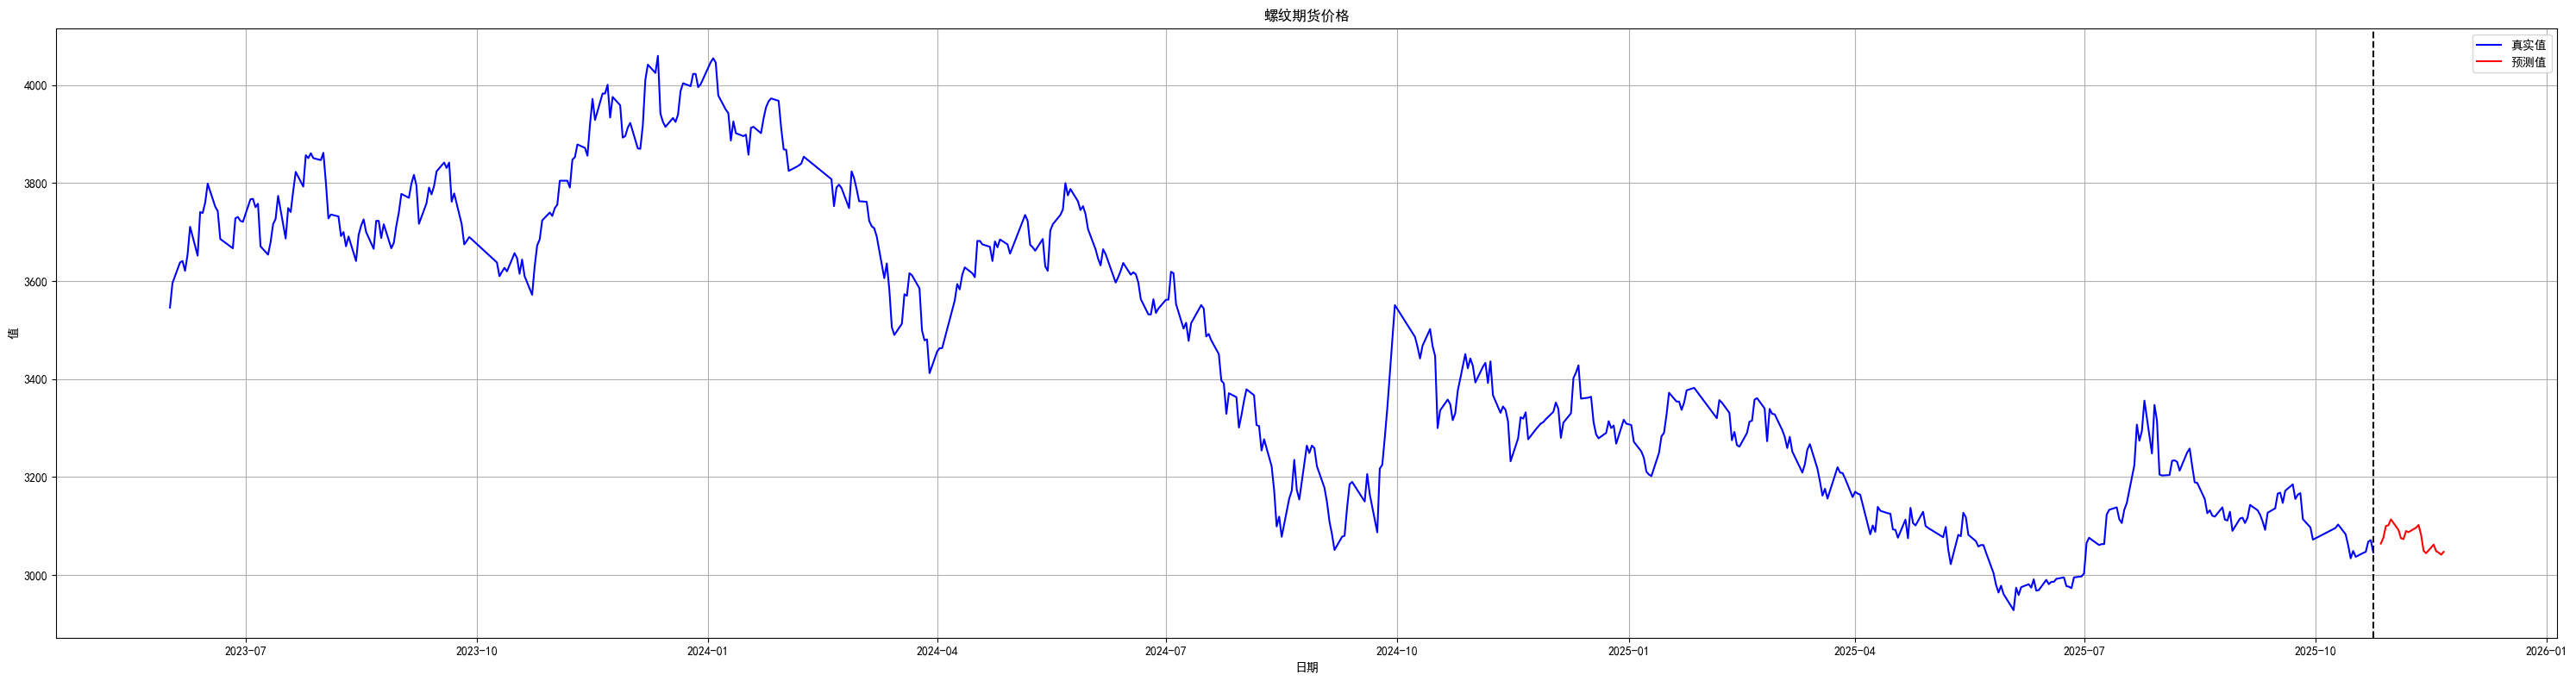

In [12]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['螺纹期货价格'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['螺纹期货价格_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('螺纹期货价格')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.螺纹_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "螺纹期货价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.螺纹_数据上传.xlsx"
sheet_name = "详情页"
identifier = "螺纹期货价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
